# Imports

In [1]:
import json
import locale
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from stock_modules.stock_transform import (create_batch_xy,
                                           create_transformer_onehot_xy)

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

keras.saving.get_custom_objects().clear()

from stock_modules.stock_ml import (create_transformer_model,
                                    MultiSoftmaxLoss, MultiAccuracy)

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_direction_model)

import matplotlib.pyplot as plt
%matplotlib widget

from stock_modules.stock_plot import plot_mask_and_data

2023-12-11 17:44:35.081410: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-11 17:44:35.105009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 17:44:35.105030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 17:44:35.105035: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 17:44:35.108914: I tensorflow/core/platform/cpu_feature_g

# Constants

In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
MODEL_SERIAL = "transformer_model_final"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"

TEST_FRAC = 0.2
PREDICT_PRICES = False

# Data Import

In [3]:
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH,
                                  "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)

DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns

# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}

print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE', 'OLVAS.HE', 'HUH1V.HE',
       'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE', 'ALBBV.HE', 'VALMT.HE',
       'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 14)
Dataframe head: 
                       REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   

                      HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                        
2021-10-12 07:00:00  38.529999      23.0  38.049999  43.139999  

# Data Treatment

In [4]:
test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))

if PREDICT_PRICES:
    scaler = MinMaxScaler()

    scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
    transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        if isinstance(df, pd.DataFrame):
            return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
        elif isinstance(df, np.ndarray):
            return scaler.inverse_transform(df)

# If we are predicting the up/down, we create a dataframe where we subtract the previous value from the current value
else:
    # Do not diff the Time Delta column
    df = DATAFRAME.copy()
    if HAS_TIMEDELTA:
        td_col = df["Time Delta"]
        df.drop("Time Delta", axis=1, inplace=True)
    transformed_df = df.diff()
    # The first row is NaN, so lets copy the second row there
    transformed_df.iloc[0, :] = transformed_df.iloc[1, :]
    # Add back the Time Delta column
    if HAS_TIMEDELTA:
        transformed_df["Time Delta"] = td_col
        # Make Time Delta the first column
        cols = transformed_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        transformed_df = transformed_df[cols]
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        return df

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  OLVAS.HE  \
date                                                                    
2021-10-12 07:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   
2021-10-12 08:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   

                     HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  VAIAS.HE  \
date                                                                    
2021-10-12 07:00:00  0.030003       0.0       0.0  0.360001 -0.200001   
2021-10-12 08:00:00  0.030003       0.0       0.0  0.360001 -0.200001   

                     ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                         
2021-10-12 07:00:00  0.099998  0.139999       0.1  0.049999  
2021-10-12 08:00:00  0.099998  0.139999       0.1  0.049999  
Transformed df shape:  (4389, 14)


# Model Optimization

2023-12-11 17:44:37.945509: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-12-11 17:44:37.945533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Jorogumo
2023-12-11 17:44:37.945536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Jorogumo
2023-12-11 17:44:37.945697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.129.3
2023-12-11 17:44:37.945709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.129.3
2023-12-11 17:44:37.945711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.129.3


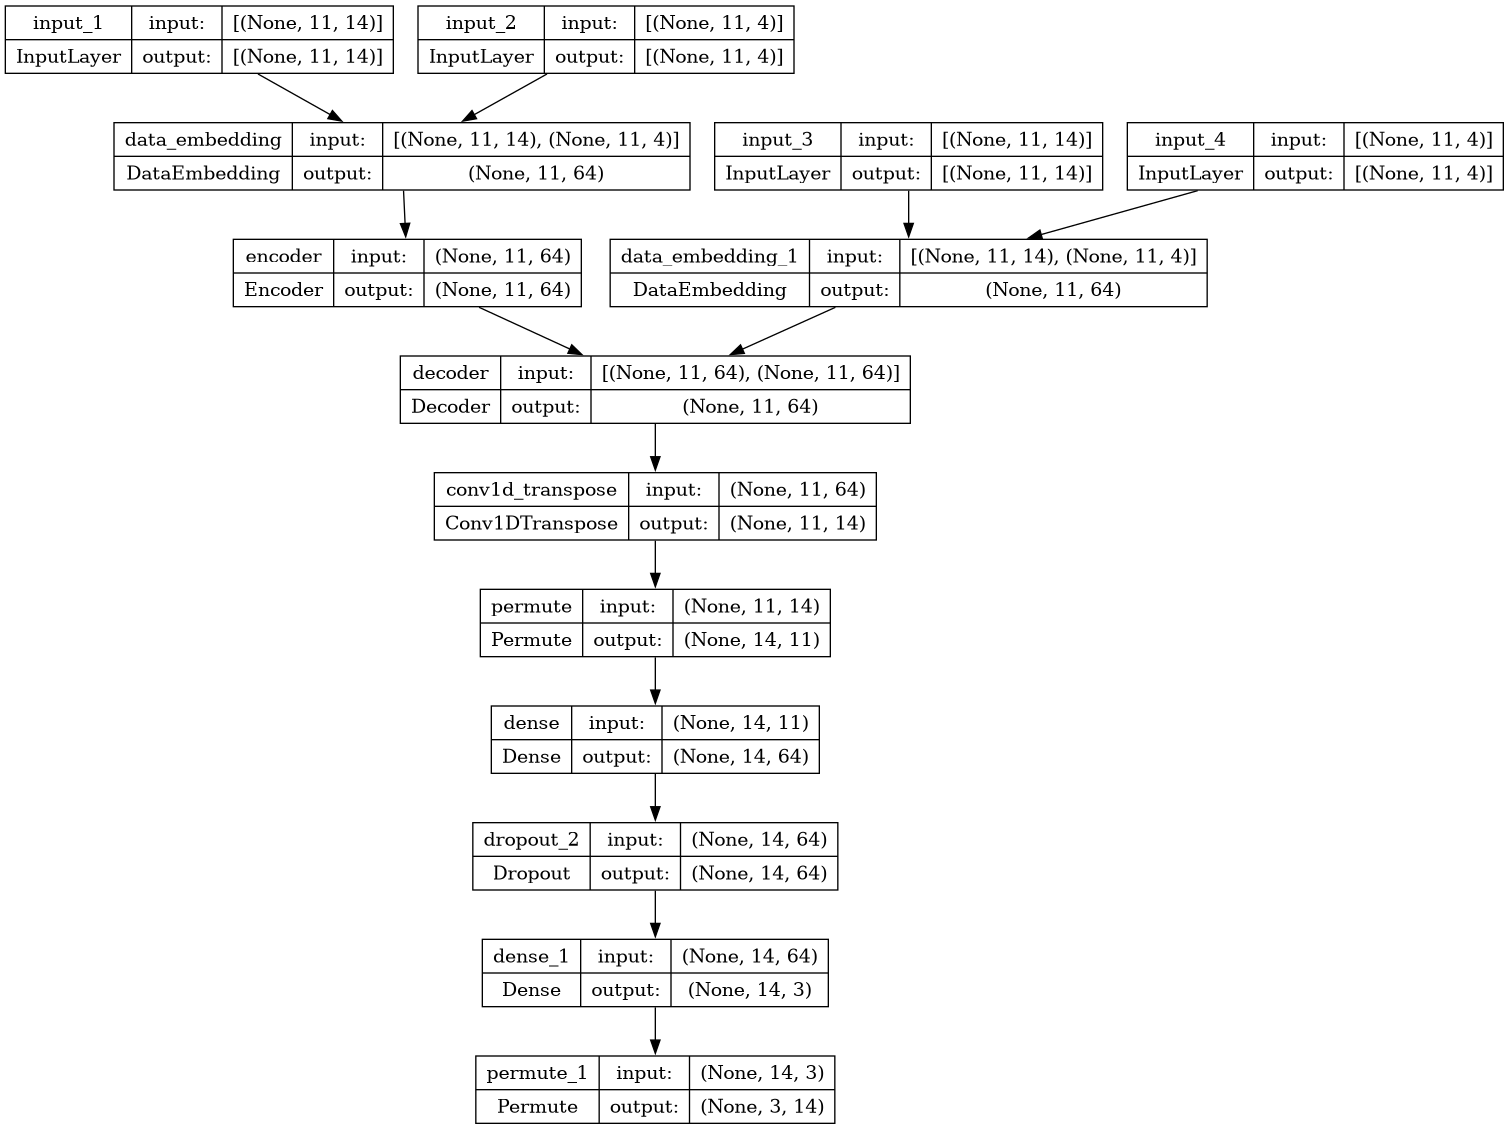

In [5]:
if not os.path.exists("./models/"):
    os.makedirs("./models/")

CLASS_FIRST = True

if MODEL_SERIAL is None:
    counter = 0
    RESUME = 0

    for memory_length in [10]:
        if PREDICT_PRICES:
            OUTPUT_SCALE = (0,1)
            x, y = create_batch_xy(
                        memory_length,
                        transformed_np_arr,
                        overlap=True,
                        y_updown=False,
                        diff_data=True,
                        output_scale=OUTPUT_SCALE)
        else:
            x, x_ts, y = create_transformer_onehot_xy(
                                memory_length,
                                transformed_np_arr,
                                DATAFRAME.to_numpy(),
                                DATAFRAME.index.to_numpy(),
                                0.002)

        split_idx = int(x.shape[0] * (1 - TEST_FRAC))

        x_train = x[:split_idx,:,:]
        x_ts_train = x_ts[:split_idx,:,:]
        y_train = y[:split_idx,:,:]

        x_test = x[split_idx:,:,:]
        x_ts_test = x_ts[split_idx:,:,:]
        y_test = y[split_idx:,:,:]

        if CLASS_FIRST:
            y_train = tf.transpose(y_train, (0,2,1))
            y_test = tf.transpose(y_test, (0,2,1))

        for head_size in [32]:
            for num_heads in [16]:
                for ff_dim in [32]:
                    for num_transformer_blocks in [4]:
                        for mlp_units in [64]:
                            for random_seed in [0,1,2]:
                                if counter < RESUME:
                                    counter = counter + 1
                                    continue

                                keras.utils.set_random_seed(random_seed)
                                
                                serial = "transformer_model_" \
                                    + datetime.now().strftime("%Y%m%d%H%M%S")
                                model_dict = {
                                    "serial": serial,
                                    "memory_length": memory_length,
                                    "head_size": head_size,
                                    "num_heads": num_heads,
                                    "ff_dim": ff_dim,
                                    "num_transformer_blocks": \
                                        num_transformer_blocks,
                                    "mlp_units": mlp_units,
                                    "seed": random_seed
                                }

                                model = create_transformer_model(
                                    m=memory_length+1,
                                    n=len(SELECTED_TICKERS),
                                    output_dim=3,
                                    head_size=head_size,
                                    num_heads=num_heads,
                                    ff_dim=ff_dim,
                                    num_transformer_blocks=
                                        num_transformer_blocks,
                                    mlp_units=(mlp_units,),
                                    class_first=CLASS_FIRST
                                )                       

                                model.compile(optimizer=keras.optimizers.Adam(),
                                            loss=MultiSoftmaxLoss(),
                                            metrics=[MultiAccuracy()])

                                model.fit(x =
                                        (x_train,x_ts_train,x_train,x_ts_train),
                                        y = y_train,
                                        batch_size=32,
                                        epochs=50,
                                        validation_split=0.25,
                                        callbacks=[
                                            keras.callbacks.EarlyStopping(
                                                patience=5,
                                                restore_best_weights=True
                                            )
                                        ])
                                
                                model.save("./models/"+serial+".keras")

                                model_dict.update(model.evaluate(
                                            x =(x_test,
                                                x_ts_test,
                                                x_test,
                                                x_ts_test),
                                            y = y_test,
                                            batch_size=32,
                                            workers=4,
                                            use_multiprocessing=True,
                                            return_dict=True
                                        )
                                    )
                                
                                if os.path.exists("./transformer_results.json"):
                                    with open("./transformer_results.json", "r",
                                            encoding=ENCODING) as json_file:
                                        model_list = json.load(json_file)
                                    model_list.append(model_dict)
                                else:
                                    model_list = [model_dict]

                                with open("./transformer_results.json", "w",
                                        encoding=ENCODING) as json_file:
                                    json.dump(model_list, json_file)

                                keras.backend.clear_session()

    if os.path.exists("./transformer_results.json"):
        with open("./transformer_results.json", "r",
                  encoding=ENCODING) as json_file:
            model_list = json.load(json_file)
    else:
        model_list = [{}]
    
    model_df = pd.DataFrame.from_dict(model_list)
    model_df.to_excel("./transformer_results.xlsx")
else:
    model = keras.models.load_model("./models/" + MODEL_SERIAL + ".keras")
    memory_length = model.input_shape[0][1]-1

    if PREDICT_PRICES:
        OUTPUT_SCALE = (0,1)
        x, y = create_batch_xy(
                    memory_length,
                    transformed_np_arr,
                    overlap=True,
                    y_updown=False,
                    diff_data=True,
                    output_scale=OUTPUT_SCALE)
    else:
        x, x_ts, y = create_transformer_onehot_xy(
                            memory_length,
                            transformed_np_arr,
                            DATAFRAME.to_numpy(),
                            DATAFRAME.index.to_numpy(),
                            0.002)

    split_idx = int(x.shape[0] * (1 - TEST_FRAC))

    x_train = x[:split_idx,:,:]
    x_ts_train = x_ts[:split_idx,:,:]
    y_train = y[:split_idx,:,:]

    x_test = x[split_idx:,:,:]
    x_ts_test = x_ts[split_idx:,:,:]
    y_test = y[split_idx:,:,:]

    if CLASS_FIRST:
        y_train = tf.transpose(y_train, (0,2,1))
        y_test = tf.transpose(y_test, (0,2,1))
plot_model(
        model,
        to_file="./figures/transformer_model_plot.png",
        show_shapes=True,
        show_layer_names = True
    )

# Benchmark

## Accuracy

In [10]:
y_pred = model([x_test, x_ts_test, x_test, x_ts_test], training=False)
print("Y_pred: \n", y_pred)
print("Y_test: \n", y_test)

for stock_idx in range(y_pred.shape[2] if CLASS_FIRST else y_pred.shape[1]):
    if CLASS_FIRST:
        direction_preds = y_pred[:,:,stock_idx]
        direction_true = y_test[:,:,stock_idx]
    else:
        direction_preds = y_pred[:,stock_idx,:]
        direction_true = y_test[:,stock_idx,:]

    direction_preds = np.argmax(direction_preds, axis=1)
    direction_true = np.argmax(direction_true, axis=1)

    accuracy = \
        np.sum(direction_preds == direction_true) / direction_preds.shape[0]
    print(f"""
            Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}:
            {accuracy}
            """
        )

Y_pred: 
 tf.Tensor(
[[[ 0.7257308   0.6798724   0.33147037 ...  0.6999614   0.6798457
    1.1853505 ]
  [ 1.108393    0.9185053   1.0788792  ...  1.197208    0.95556337
    1.1198826 ]
  [ 1.6619374   1.4344898   1.6039238  ...  1.1869426   1.6975129
    1.4814094 ]]

 [[ 1.5136701   1.3229641   0.5461215  ...  1.3278407   1.0664978
    0.87657046]
  [ 0.948695    1.1375785   1.1480697  ...  1.3869661   1.1586384
    0.71539307]
  [ 0.62773216  1.7308099   1.6180451  ...  1.1715257   1.9906563
    0.51409584]]

 [[ 1.4657341   0.9653202   0.5264274  ...  0.8522787   1.1668204
    0.01511547]
  [ 1.1540734   0.9757079   1.1442806  ...  1.2423041   1.1619524
    0.9253416 ]
  [ 0.6741441   1.7661186   1.2537961  ...  1.3963487   1.6536843
    1.940138  ]]

 ...

 [[ 1.1129472   0.5784117   1.2387781  ...  1.1599243   1.4189594
    1.8742728 ]
  [ 0.89924014  0.9244496   0.98836285 ...  1.3575083   1.2851938
    1.0879084 ]
  [ 0.65624213  1.4258316   0.39298576 ...  1.0864451   1.684083

## Profitability

In [7]:
# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 3rd stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test,
                                                     optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = \
    strategy_mask_from_direction_model(transformed_np_arr_test,
                                       memory_length, model,
                                       True, df.to_numpy()[-test_sz:,:],
                                       df.index.to_numpy()[-test_sz:]
                                       )

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 3rd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test[:,1:],
                                            prediction_trading_mask)
else:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test,
                                            prediction_trading_mask)

print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(
    f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 3rd stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

## Plotting

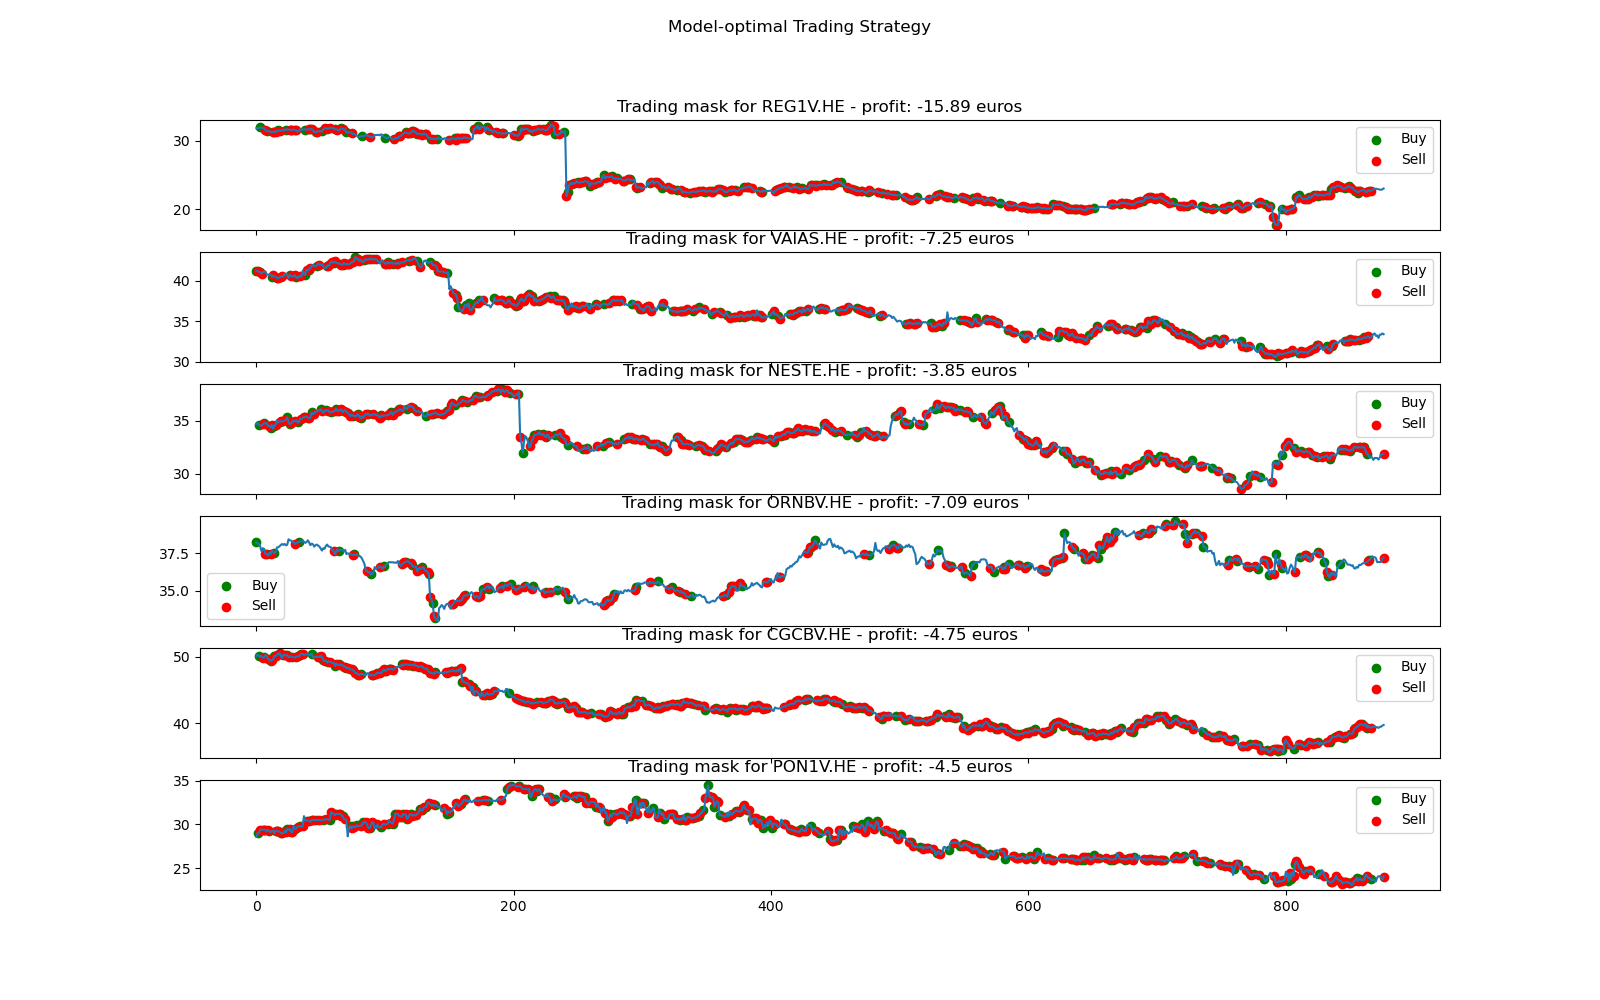

(<Figure size 1600x1000 with 6 Axes>,
 array([<Axes: title={'center': 'Trading mask for REG1V.HE - profit: -15.89 euros'}>,
        <Axes: title={'center': 'Trading mask for VAIAS.HE - profit: -7.25 euros'}>,
        <Axes: title={'center': 'Trading mask for NESTE.HE - profit: -3.85 euros'}>,
        <Axes: title={'center': 'Trading mask for ORNBV.HE - profit: -7.09 euros'}>,
        <Axes: title={'center': 'Trading mask for CGCBV.HE - profit: -4.75 euros'}>,
        <Axes: title={'center': 'Trading mask for PON1V.HE - profit: -4.5 euros'}>],
       dtype=object))

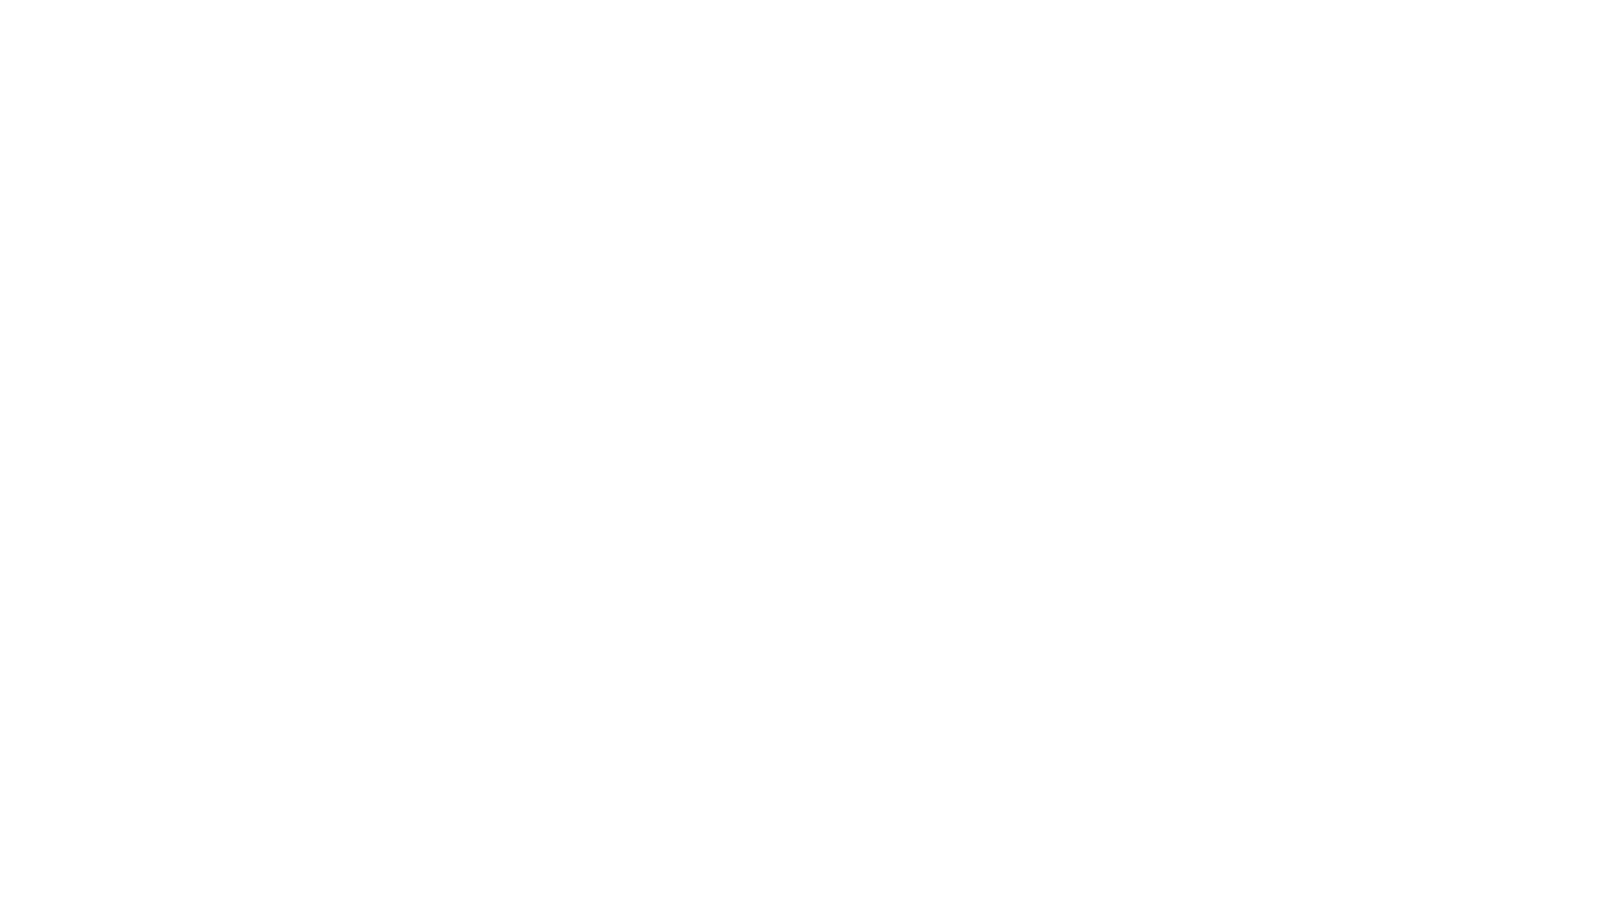

In [8]:
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 6,
                                 replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]

ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plt.figure(figsize=(16,9))
plot_mask_and_data(part_mask, part_price, ind_conversion)